In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
from IPython.display import Image, display
#import PIL

In [203]:
#pretrained 16 layer CNN
import vgg16

In [204]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [205]:
#Image helper functions
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

In [206]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [207]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [208]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show() 

In [209]:
#Loss function returns a scalar value
#a can be our content image or our style image
#b will be our feature map
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [210]:
def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    layers = model.get_layer_tensors(layer_ids)
    values = session.run(layers, feed_dict = feed_dict)
    with model.graph.as_default():
        layer_losses = []
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
    return total_loss

In [211]:
def get_gram_matrix(tensor):
    #4d tensor that is collection of 3d tensors (RGB images)
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix = tf.reshape(tensor, shape = [-1, num_channels]) #flattening the contents of each of the feature channels
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

In [212]:
def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image = style_image)
    layers = model.get_layer_tensors(layer_ids)
    with model.graph.as_default():
        gram_layers = [get_gram_matrix(layer) for layer in layers]
        values = session.run(gram_layers, feed_dict = feed_dict)
        layer_losses = []
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
    return total_loss

In [213]:
#also calld total variation loss - helps supress noise in the image
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))
    return loss

In [214]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    
    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph = model.graph) #session always encapsulates our computation graph
    
    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)
    loss_denoise = create_denoise_loss(model)
    
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    
    session.run([adj_content.initializer, adj_style.initializer, adj_denoise.initializer])
    
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    
    loss_combined = weight_content*adj_content*loss_content + weight_style*adj_style*loss_style + weight_denoise*adj_denoise*loss_denoise
    
    gradient = tf.gradients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]
    
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image = mixed_image)
        grad, adj_content_val, adj_style_val, adj_denoise_val = session.run(run_list, feed_dict=feed_dict)
        grad = np.squeeze(grad)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        mixed_image -= grad * step_size_scaled #gradient descent step
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        print(". ", end="")
        
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image, style_image=style_image, mixed_image=mixed_image)
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [225]:
content_filename = 'images/giger.jpg'
content_image = load_image(content_filename, max_size=None)

In [223]:
style_filename = 'images/style2.jpg'
style_image = load_image(style_filename, max_size=300)

In [217]:
content_layer_ids = [4]

In [218]:
style_layer_ids = list(range(13))

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 9.26e-11, Style: 2.41e-30, Denoise: 5.69e-07


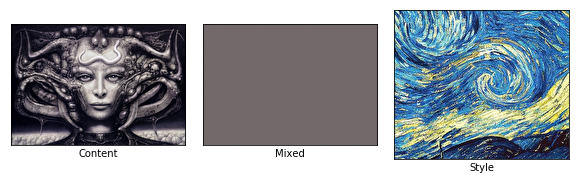

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.74e-10, Style: 6.38e-29, Denoise: 3.33e-08


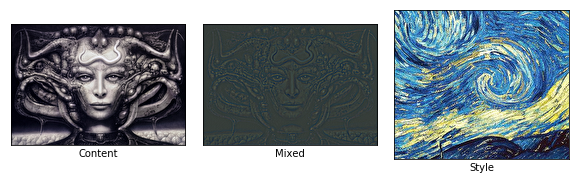

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.78e-10, Style: 3.71e-28, Denoise: 2.72e-08


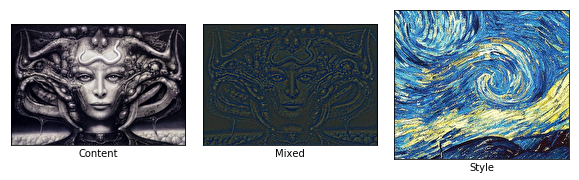

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.98e-10, Style: 7.36e-28, Denoise: 2.33e-08


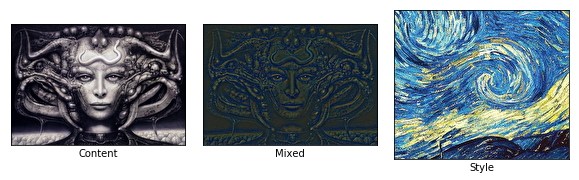

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 2.22e-10, Style: 8.98e-28, Denoise: 2.24e-08


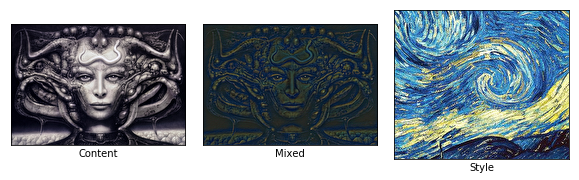

. . . . . . . . . 
Iteration: 49
Weight Adj. for Content: 1.92e-10, Style: 3.57e-29, Denoise: 1.46e-08


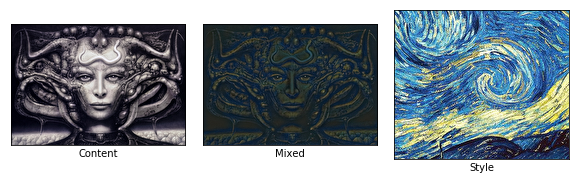


Final image:


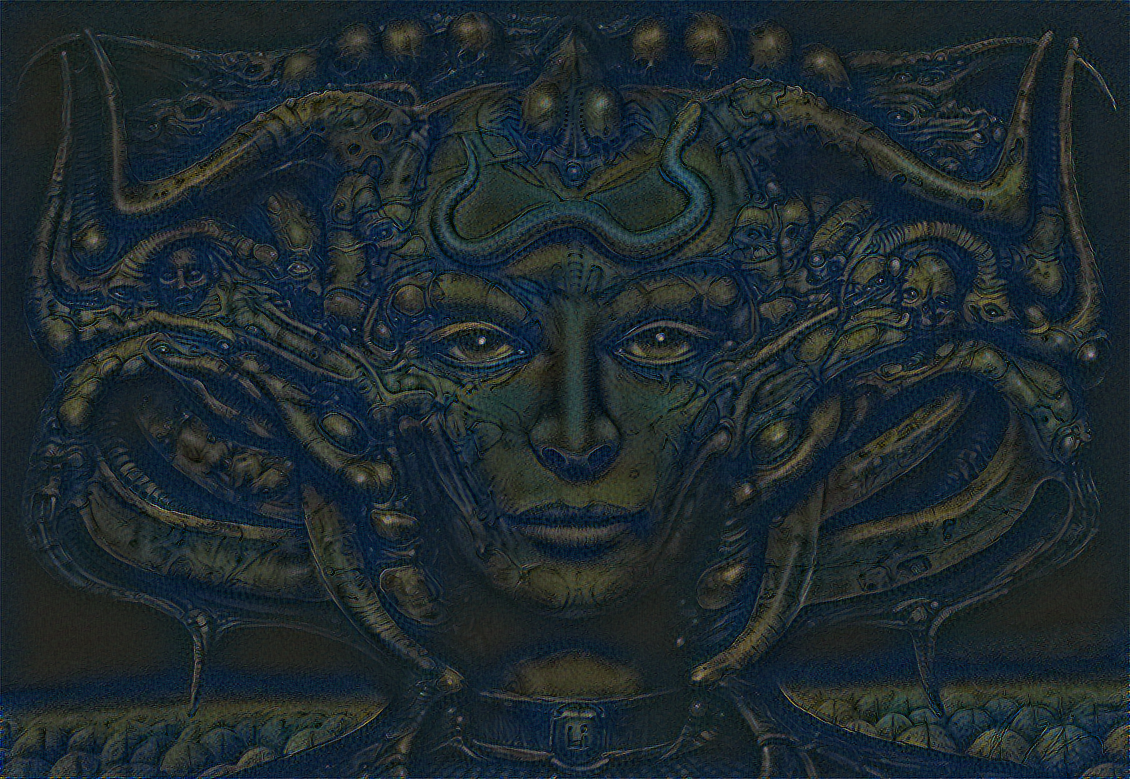

Wall time: 22min 1s


In [226]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=50,
                     step_size=10.0)